In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'covid19-image-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F627146%2F1117472%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240725%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240725T140130Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D92c99f81dc9c003d77b95878891f33e63b2eaf0d308989235aacef89089dc6cb22c1ea5bae875dfb25dc0ce138f217c8ee4aee31dcf980ab77cd5930887bdd9e9909c01b936e814d65cff0b1e7420f977f09f00cb9c00ef4b18b8e0503bc3961fb0e9e3268c5e5fac77a478046bff6dab59f063f3d29173b4bd27325e55b9a24fb5cfbeb0e52ba33aba41ea4d16061e6a3f4689cfe65bafc2efa02d8242692a1bf869e9cf02e31ab01eaac1c88287f10d457f5b3b0eb07a82226aa13355f8f8fb14748f118b0233ee9bc5a81e7b37c1fb1674c4edd7f26985ca2323e2b7b9a0a1563072f04251eb0950c5cedb6cc4c9ceaa48c24ad344202cc9f98ff8668c2f5'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 165557612 bytes downloaded
Downloaded and uncompressed: covid19-image-dataset
Data source import complete.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import image


In [ ]:
os.listdir('../input/covid19-image-dataset/Covid19-dataset')
os.listdir('../input/covid19-image-dataset/Covid19-dataset/test/Covid')


['0115.jpeg',
 '0119.jpeg',
 '0105.png',
 'auntminnie-2020_01_31_20_24_2322_2020_01_31_x-ray_coronavirus_US.jpg',
 '096.png',
 '0112.jpg',
 '0111.jpg',
 '0118.jpeg',
 'auntminnie-c-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
 '0108.jpeg',
 '0106.jpeg',
 'auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
 '0113.jpg',
 '094.png',
 'auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
 'COVID-00003b.jpg',
 '0120.jpg',
 '098.jpeg',
 'COVID-00033.jpg',
 'COVID-00022.jpg',
 'radiopaedia-2019-novel-coronavirus-infected-pneumonia.jpg',
 'auntminnie-d-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
 '0102.jpeg',
 'COVID-00012.jpg',
 '0100.jpeg',
 'COVID-00037.jpg']

In [ ]:
os.listdir('../input/covid19-image-dataset/Covid19-dataset/test/Normal')
os.listdir('../input/covid19-image-dataset/Covid19-dataset/test/Viral Pneumonia')

['0115.jpeg',
 '0119.jpeg',
 '0107.jpeg',
 '0113.jpeg',
 '0118.jpeg',
 '0110.jpeg',
 '0116.jpeg',
 '0117.jpeg',
 '0108.jpeg',
 '0106.jpeg',
 '0114.jpeg',
 '0111.jpeg',
 '0109.jpeg',
 '0104.jpeg',
 '0120.jpeg',
 '0102.jpeg',
 '0112.jpeg',
 '0103.jpeg',
 '0105.jpeg',
 '0101.jpeg']

uint8
(659, 651, 3)


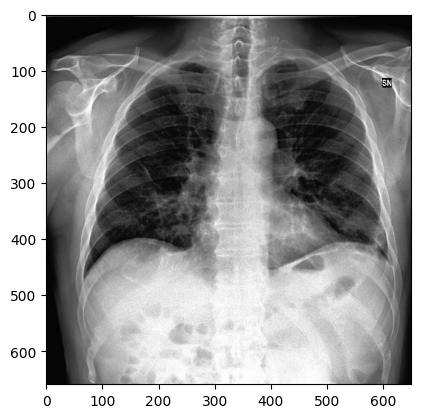

In [ ]:
# load and display an image with Matplotlib
from matplotlib import image
from matplotlib import pyplot
# load image as pixel array
data = image.imread('../input/covid19-image-dataset/Covid19-dataset/test/Covid/0100.jpeg')
# summarize shape of the pixel array
print(data.dtype)
print(data.shape)
# display the array of pixels as an image
pyplot.imshow(data)
pyplot.show()

In [ ]:
# function that would read an image provided the image path, preprocess and return it back

def read_and_preprocess(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR) # reading the image
    img = cv2.resize(img, (256, 256)) # resizing it (I just like it to be powers of 2)
    img = np.array(img, dtype='float32') # convert its datatype so that it could be normalized
    img = img/255 # normalization (now every pixel is in the range of 0 and 1)
    return img

In [ ]:
X_train = [] # To store train images
y_train = [] # To store train labels

# labels -
# 0 - Covid
# 1 - Viral Pneumonia
# 2 - Normal

train_path = "../input/covid19-image-dataset/Covid19-dataset/train/" # path containing training image samples

In [ ]:
import cv2
for folder in os.scandir(train_path):
    for entry in os.scandir(train_path + folder.name):

        X_train.append(read_and_preprocess(train_path + folder.name + '/' + entry.name))

        if folder.name[0]=='C':
            y_train.append(0)
        elif folder.name[0]=='V':
            y_train.append(1)
        else:
            y_train.append(2)

In [ ]:
X_train = np.array(X_train)
X_train.shape # We have 251 training samples in total

(251, 256, 256, 3)

In [ ]:
y_train = np.array(y_train)
y_train.shape

(251,)

<BarContainer object of 3 artists>

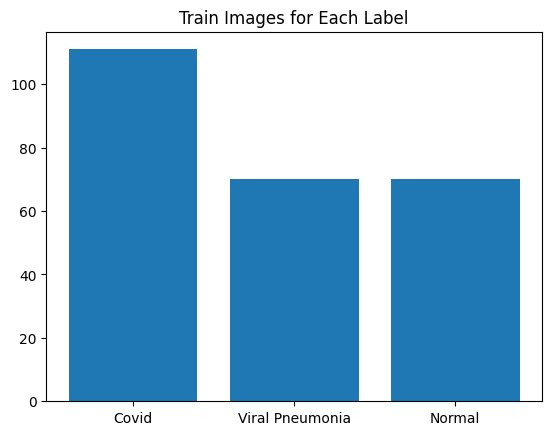

In [ ]:
#Visualizing the Dataset
covid_count = len(y_train[y_train==0])
pneumonia_count = len(y_train[y_train==1])
normal_count = len(y_train[y_train==2])

plt.title("Train Images for Each Label")
plt.bar(["Covid", "Viral Pneumonia", "Normal"],[covid_count, pneumonia_count, normal_count])

In [ ]:
# We have more number of covid samples that Pneumonia and Normal


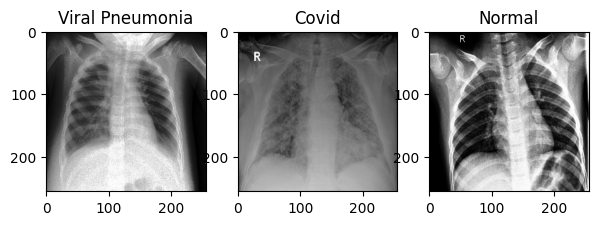

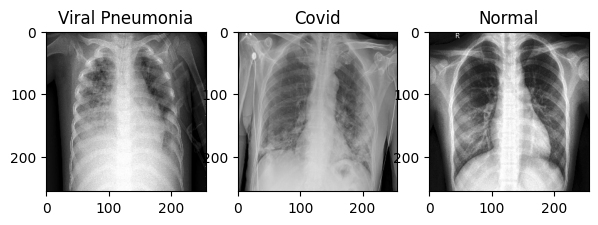

In [ ]:
# Plotting 2 images per disease

import random

title = {0:"Covid", 1:"Viral Pneumonia", 2:"Normal"}

rows = 2
columns = 3

for i in range(2):

    fig = plt.figure(figsize=(7,7))

    fig.add_subplot(rows, columns, 1)
    pos = random.randint(0, covid_count)
    plt.imshow(X_train[pos])
    plt.title(title[y_train[pos]])

    fig.add_subplot(rows, columns, 2)
    pos = random.randint(covid_count, covid_count+pneumonia_count)
    plt.imshow(X_train[pos])
    plt.title(title[y_train[pos]])

    fig.add_subplot(rows, columns, 3)
    pos = random.randint(covid_count+pneumonia_count, covid_count+pneumonia_count+normal_count)
    plt.imshow(X_train[pos])
    plt.title(title[y_train[pos]])

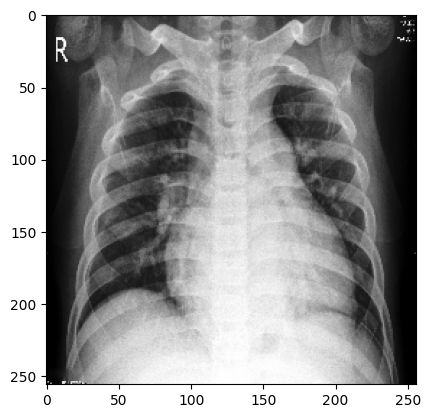

In [ ]:
#image augmentation
plt.imshow(X_train[0])

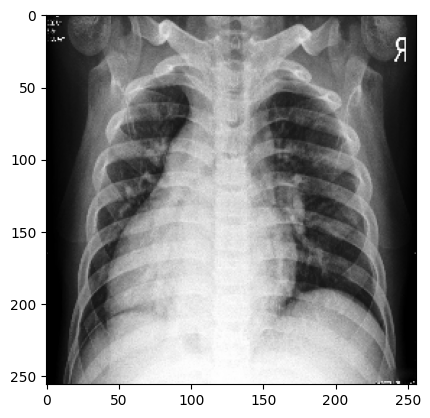

In [ ]:
X_new = np.fliplr(X_train[0])
plt.imshow(X_new)

In [ ]:
X_aug = []
y_aug = []

for i in range(0, len(y_train)):
    X_new = np.fliplr(X_train[i])
    X_aug.append(X_new)
    y_aug.append(y_train[i])

In [ ]:
X_aug = np.array(X_aug)
y_aug = np.array(y_aug)

In [ ]:
X_train = np.append(X_train, X_aug, axis=0) # appending augmented images to original training samples
X_train.shape

(502, 256, 256, 3)

In [ ]:
y_train = np.append(y_train, y_aug, axis=0)
y_train.shape

(502,)

In [ ]:
X_val = [] # To store validation and test images
y_val = [] # To store validation and test labels

val_path = '../input/covid19-image-dataset/Covid19-dataset/test/'

for folder in os.scandir(val_path):
    for entry in os.scandir(val_path + folder.name):

        X_val.append(read_and_preprocess(val_path + folder.name + '/' + entry.name))

        if folder.name[0]=='C':
            y_val.append(0)
        elif folder.name[0]=='V':
            y_val.append(1)
        else:
            y_val.append(2)

X_val = np.array(X_val)
y_val = np.array(y_val)

In [ ]:
X_val.shape # We have 66 images for validation and testing

(66, 256, 256, 3)

<BarContainer object of 3 artists>

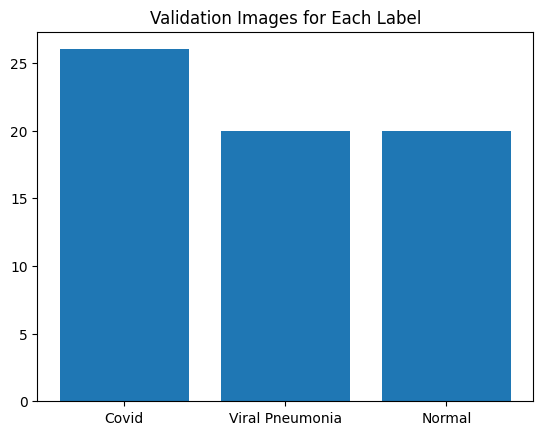

In [ ]:
covid_count = len(y_val[y_val==0])
pneumonia_count = len(y_val[y_val==1])
normal_count = len(y_val[y_val==2])

plt.title("Validation Images for Each Label")
plt.bar(["Covid", "Viral Pneumonia", "Normal"],[covid_count, pneumonia_count, normal_count])

# We have more number of covid samples that Pneumonia and Normal in test dataset as well

In [ ]:
model1=Sequential()
model1.add(Conv2D(32,(3,3),activation='relu',input_shape=(256,256,3)))

model1.add(Conv2D(64,(3,3),activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(128,(3,3),activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Dropout(0.25))

model1.add(Flatten())

model1.add(Dense(64,activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(3,activation='softmax'))

model1.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,optimizer='SGD',metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 126, 126, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 128)       0         
 g2D)                                                   

In [ ]:
basic1 = model1.fit(X_train, y_train, epochs = 20, validation_data=(X_val, y_val), batch_size=8)

Epoch 1/20
63/63 [==============================] - 247s 4s/step - loss: 0.9585 - accuracy: 0.5598 - val_loss: 0.8350 - val_accuracy: 0.6364
Epoch 2/20
63/63 [==============================] - 252s 4s/step - loss: 0.6247 - accuracy: 0.7271 - val_loss: 0.7180 - val_accuracy: 0.7424
Epoch 3/20
63/63 [==============================] - ETA: 0s - loss: 0.4823 - accuracy: 0.8108

In [ ]:
plt.plot(basic1.history['loss'])
plt.plot(basic1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
plt.plot(basic1.history['accuracy'])
plt.plot(basic1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions = model1.predict(X_val)

In [ ]:
predictions.shape


In [ ]:
# Obtain the predicted class from the model prediction
predict = []

for i in predictions:
  predict.append(np.argmax(i))

predict = np.asarray(predict)

In [ ]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_val, predict)
accuracy

In [ ]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, predict)

plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True, cmap='Blues')

In [ ]:
# The model misclassified one Normal case as Pneumonia

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_val, predict)
print(report)

In [ ]:
#test images
from tensorflow.keras.preprocessing import image
path='../input/covid19-image-dataset/Covid19-dataset/test/Covid/COVID-00003b.jpg'
img=image.load_img(path,target_size=(256,256))
img=image.img_to_array(img)/255
#convert to 1D array
img=np.array([img])
img.shape
#now predict
result=np.argmax(model1.predict(img))
print(result)
if result==0:
    print("covid")
elif(result==1):
    print("Normal")
elif result==2:
    print("viral pneumonia")


In [ ]:
# lets create model 2 with an optimiser as Adam

In [ ]:
model3=Sequential()
model3.add(Conv2D(32,(3,3),activation='relu',input_shape=(256,256,3)))

model3.add(Conv2D(64,(3,3),activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Dropout(0.25))

model3.add(Conv2D(128,(3,3),activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Dropout(0.25))

model3.add(Flatten())
model3.add(Dense(64,activation='relu'))
model3.add(Dropout(0.5))

model3.add(Dense(3,activation='softmax'))

model3.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,optimizer='Adam',metrics=['accuracy'])
model3.summary()

In [ ]:
basic3 = model3.fit(X_train, y_train, epochs = 20, validation_data=(X_val, y_val), batch_size=8)

In [ ]:
plt.plot(basic3.history['loss'])
plt.plot(basic3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
plt.plot(basic3.history['accuracy'])
plt.plot(basic3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions3 = model3.predict(X_val)
predictions3.shape
# Obtain the predicted class from the model prediction
predict3 = []

for i in predictions3:
     predict3.append(np.argmax(i))

predict3 = np.asarray(predict3)
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score
accuracy3 = accuracy_score(y_val, predict3)
accuracy3

In [ ]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm3 = confusion_matrix(y_val, predict3)

plt.figure(figsize = (7,7))
sns.heatmap(cm3, annot=True, cmap='Blues')

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_val, predict3)
print(report)

In [ ]:
#model with adam and more conv2d layers
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(256,256,3)))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(3,activation='softmax'))

model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,optimizer='Adam',metrics=['accuracy'])
model.summary()


In [ ]:
basic4 = model.fit(X_train, y_train, epochs = 50, validation_data=(X_val, y_val), batch_size=16)

In [ ]:
plt.plot(basic4.history['loss'])
plt.plot(basic4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
plt.plot(basic4.history['accuracy'])
plt.plot(basic4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions4 = model.predict(X_val)
predictions4.shape
# Obtain the predicted class from the model prediction
predict4 = []

for i in predictions4:
     predict4.append(np.argmax(i))

predict4 = np.asarray(predict4)
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score
accuracy4 = accuracy_score(y_val, predict4)
accuracy4

In [ ]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm4 = confusion_matrix(y_val, predict4)

plt.figure(figsize = (7,7))
sns.heatmap(cm4, annot=True, cmap='Blues')

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_val, predict4)
print(report)

In [ ]:
#model 5 with more layers and rmsprop
#model with adam and more conv2d layers
model5=Sequential()
model5.add(Conv2D(32,(3,3),activation='relu',input_shape=(256,256,3)))

model5.add(Conv2D(64,(3,3),activation='relu'))
model5.add(MaxPooling2D(pool_size=(2,2)))
model5.add(Dropout(0.25))

model5.add(Conv2D(128,(3,3),activation='relu'))
model5.add(MaxPooling2D(pool_size=(2,2)))
model5.add(Dropout(0.25))

model5.add(Conv2D(256,(3,3),activation='relu'))
model5.add(MaxPooling2D(pool_size=(2,2)))
model5.add(Dropout(0.25))

model5.add(Conv2D(256,(3,3),activation='relu'))
model5.add(MaxPooling2D(pool_size=(2,2)))
model5.add(Dropout(0.25))

model5.add(Flatten())

model5.add(Dense(64,activation='relu'))
model5.add(Dropout(0.5))

model5.add(Dense(3,activation='softmax'))

model5.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,optimizer='RMSprop',metrics=['accuracy'])
model5.summary()


In [ ]:
basic5 = model5.fit(X_train, y_train, epochs = 50, validation_data=(X_val, y_val), batch_size=16)

In [ ]:
plt.plot(basic5.history['loss'])
plt.plot(basic5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
plt.plot(basic5.history['accuracy'])
plt.plot(basic5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions5 = model5.predict(X_val)
predictions5.shape
# Obtain the predicted class from the model prediction
predict5 = []

for i in predictions5:
     predict5.append(np.argmax(i))

predict5 = np.asarray(predict5)
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score
accuracy5 = accuracy_score(y_val, predict5)
accuracy5

In [ ]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm5 = confusion_matrix(y_val, predict5)

plt.figure(figsize = (7,7))
sns.heatmap(cm5, annot=True, cmap='Blues')

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_val, predict5)
print(report)

In [ ]:
#test images
from tensorflow.keras.preprocessing import image
path='../input/covid19-image-dataset/Covid19-dataset/test/Covid/COVID-00003b.jpg'
img=image.load_img(path,target_size=(256,256))
img=image.img_to_array(img)/255
#convert to 1D array
img=np.array([img])
img.shape
#now predict
result=np.argmax(model5.predict(img))
print(result)
if result==0:
    print("covid")
elif(result==1):
    print("Normal")
elif result==2:
    print("viral pneumonia")
